# Building a multivariate time series model with darts

In [1]:
from darts import TimeSeries
import pandas as pd
from definitions import MEASUREMENTS, TARGETS
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.models import RNNModel, TCNModel
import matplotlib.pyplot as plt
from darts.metrics import mape, smape
import pickle
from pyprocessta.preprocess.resample import resample_regular
import numpy as np 
import datetime as dt 

MEAS_COLUMNS =["TI-19",
    "FI-16",
    "TI-33",
    "FI-2",
    "FI-151",
    "TI-8",
    "FI-241",
   # "Level Desorber",
   # "Reboiler level",
   # "valve-position-12",
    "FI-38",
    "FI-20",
    "FI-30",
    "TI-3",
    "FI-19",
    "FI-211",
    "FI-11",
    "TI-30",
    "PI-30",
    "TI-1213",
    "TI-4",
    "FI-23"]

Importing plotly failed. Interactive plots will not work.


In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_pickle('detrended.pkl')

In [4]:
df = df.dropna()

In [5]:
df['delta_t'] = df['TI-35'] - df["TI-4"]

In [6]:
MEAS_COLUMNS.append('delta_t')

In [7]:
good_days = [15,16, 17, 20,21,22,23,24,31,1]

In [8]:
good_rows = []
for i in range(len(df)):
    if df.index[i].day in good_days:
        good_rows.append(df.iloc[i])

In [9]:
df_downsampled = pd.DataFrame(good_rows)

In [10]:
df_downsampled.index = dt.datetime(2010,1,1) + pd.TimedeltaIndex(np.arange(len(df_downsampled))*5, unit='min')

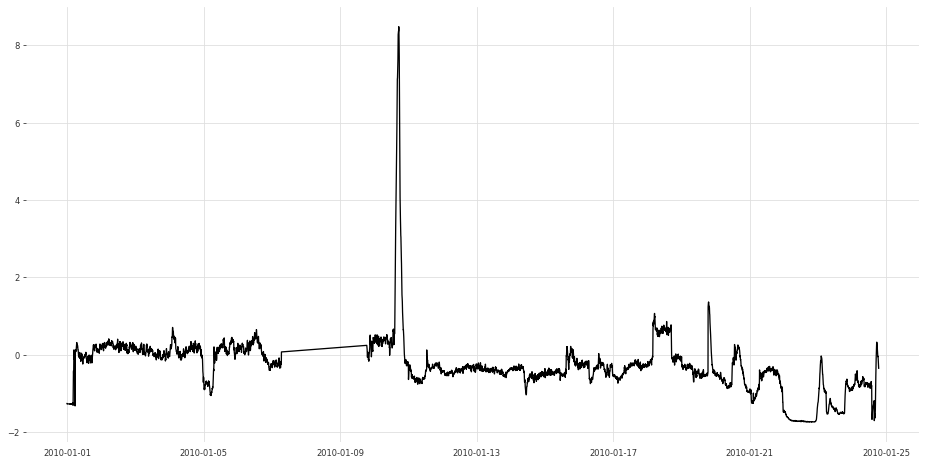

In [11]:
plt.figure(figsize=(16,8))
plt.plot(df_downsampled['Carbon dioxide CO2'])

In [70]:
#df_downsampled = resample_regular(df_downsampled, '5min')

In [71]:
df_downsampled.to_pickle('df_dropped.pkl')

In [556]:
#TARGETS.pop(0)

In [12]:
y = TimeSeries.from_dataframe(df_downsampled, value_cols=TARGETS)

In [13]:
x = TimeSeries.from_dataframe(df_downsampled, value_cols=MEAS_COLUMNS)

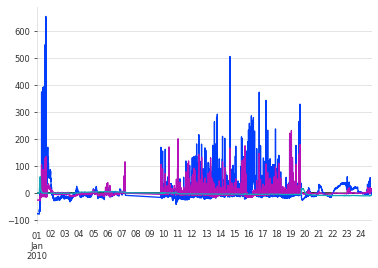

In [14]:
y.plot()

In [15]:
y_train, y_test = y.split_before(pd.Timestamp('2010-01-18 12:59:15'))
x_train, x_test = x.split_before(pd.Timestamp('2010-01-18 12:59:15'))

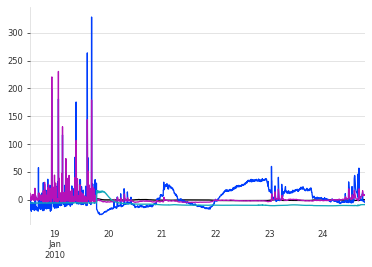

In [16]:
y_test.plot()

In [17]:
transformer = Scaler()

x_train = transformer.fit_transform(x_train)
x_test = transformer.transform(x_test)

with open('x_scaler.pkl', 'wb') as handle:
    pickle.dump(transformer, handle)
    
y_transformer = Scaler()
y_train = y_transformer.fit_transform(y_train)
y_test = y_transformer.transform(y_test)


In [563]:
with open('y_scaler.pkl', 'wb') as handle:
    pickle.dump(y_transformer, handle)

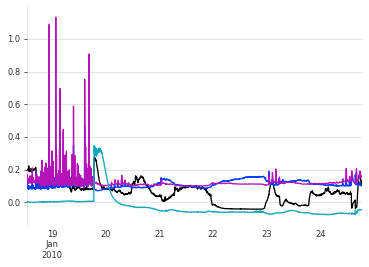

In [18]:
y_test.plot()

### RNN model

In [19]:
model_cov = TCNModel(
    input_chunk_length=8,
    output_chunk_length=1,
    num_layers=6,
    num_filters=3,
    kernel_size=2,
    dropout=0.2,
    weight_norm=True,
    batch_size=32,
    n_epochs=300)

/home/kjablonk/anaconda3/envs/timeseries_analysis/lib/python3.8/site-packages/torch/random.py:95: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(


In [20]:
from ipywidgets import FloatProgress

In [21]:
model_cov.fit(series=y_train,
              covariates=x_train,
              verbose=False)

[2021-06-15 14:55:24,682] INFO | darts.models.torch_forecasting_model | Train dataset contains 5044 samples.
[2021-06-15 14:55:24,682] INFO | darts.models.torch_forecasting_model | Train dataset contains 5044 samples.

KeyboardInterrupt



In [ ]:
backtest_cov = model_cov.historical_forecasts(y_train,
                                              covariates=x_train,
                                              start=0.2,
                                              forecast_horizon=1,
                                              stride=1,
                                              retrain=False,
                                              verbose=False)

y_train.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(y_train, backtest_cov)))

In [ ]:
backtest_cov = model_cov.historical_forecasts(y_test,
                                              covariates=x_test,
                                              start=0.05,
                                              forecast_horizon=1,
                                              stride=1,
                                              retrain=False,
                                              verbose=False)

y_test.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(y_test, backtest_cov)))

In [514]:
TARGETS

['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2', 'Ammonia NH3']

Text(0, 0.5, '2-AMP')

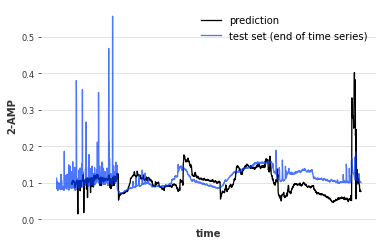

In [570]:
plt.plot(backtest_cov._df['0'], label='prediction')
plt.plot(y_test._df['0'], label='test set (end of time series)', alpha=.7)
plt.xticks([])
plt.legend()
plt.xlabel('time')
plt.ylabel('2-AMP')
#plt.savefig('amp_predictions.pdf', bbox_inches='tight')

Text(0, 0.5, 'piperazine')

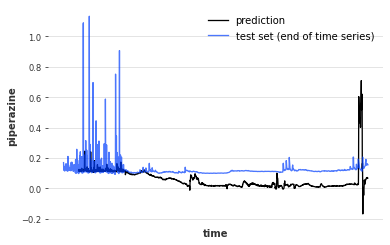

In [571]:
plt.plot(backtest_cov._df['1'], label='prediction')
plt.plot(y_test._df['1'], label='test set (end of time series)', alpha=.7)
plt.xticks([])
plt.legend()
plt.xlabel('time')
plt.ylabel('piperazine')
#plt.savefig('piperazine_predictions.pdf', bbox_inches='tight')

Text(0, 0.5, 'NH3')

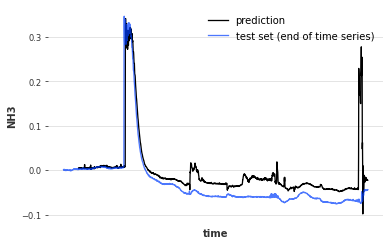

In [572]:
plt.plot(backtest_cov._df['2'], label='prediction')
plt.plot(y_test._df['2'], label='test set (end of time series)', alpha=.7)
plt.xticks([])
plt.legend()
plt.xlabel('time')
plt.ylabel('NH3')
#plt.savefig('NH3_predictions.pdf', bbox_inches='tight')

In [295]:
TARGETS

['Carbon dioxide CO2',
 '2-Amino-2-methylpropanol C4H11NO',
 'Piperazine C4H10N2',
 'Ammonia NH3']

In [72]:
x_train.copy().time_index()

DatetimeIndex(['2020-01-15 11:42:01', '2020-01-15 11:47:01',
               '2020-01-15 11:52:01', '2020-01-15 11:57:01',
               '2020-01-15 12:02:01', '2020-01-15 12:07:01',
               '2020-01-15 12:12:01', '2020-01-15 12:17:01',
               '2020-01-15 12:22:01', '2020-01-15 12:27:01',
               ...
               '2020-01-25 12:12:01', '2020-01-25 12:17:01',
               '2020-01-25 12:22:01', '2020-01-25 12:27:01',
               '2020-01-25 12:32:01', '2020-01-25 12:37:01',
               '2020-01-25 12:42:01', '2020-01-25 12:47:01',
               '2020-01-25 12:52:01', '2020-01-25 12:57:01'],
              dtype='datetime64[ns]', length=2896, freq='5T')

In [77]:
y_train.pd_dataframe().shape

(2896, 1)

In [18]:
import pickle

In [573]:
with open('multivariate_model_new.pkl', 'wb') as handle:
    pickle.dump(model_cov, handle)

### Transformer model

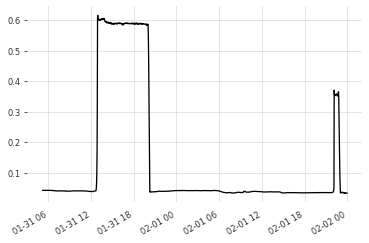

In [73]:
backtest_cov['3'].plot()

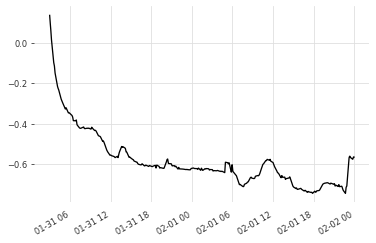

In [74]:
y_test['3'].plot(label='actual')